# Model Training

- DistilRoberta base model
- Train to classify headlines by TrendD+1 of SP500

In [1]:
!pip install datasets wandb transformers huggingface_hub

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from datasets import load_dataset

In [5]:
dataset = load_dataset("csv", data_files="/content/drive/MyDrive/SP500-Predictor/jvdm_data_sources_trends.csv" )
dataset = dataset.remove_columns([col for col in dataset["train"].column_names if col not in ["Headlines", "TrendD+1"]])
dataset = dataset.rename_column("TrendD+1", "labels")

In [6]:
train_test_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [7]:
print(train_dataset[0])
print(test_dataset[0])

{'Headlines': "Dollar index hits one-week low on Fed officials' cautious comments", 'labels': 0}
{'Headlines': 'Excellence is overrated . Let’s embrace being good enough instead', 'labels': 2}


In [8]:
label_list = dataset["train"].unique("labels")
num_labels = len(label_list)

In [9]:
label_list

[2, 1, 0]

### Load tokenizer

In [10]:
from transformers import AutoTokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
train_dataset = train_dataset.map(lambda x: tokenizer(x["Headlines"], truncation=True), batched=True)
test_dataset = test_dataset.map(lambda x: tokenizer(x["Headlines"], truncation=True), batched=True)

Map:   0%|          | 0/10666 [00:00<?, ? examples/s]

### Load pretrained model

In [13]:
from transformers import AutoModelForSequenceClassification

In [14]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilroberta-base", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train model

In [15]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

In [16]:
import wandb
wandb.login()

wandb: Currently logged in as: jeroenvdmbrugge (jeroenvdmbrugge-personal). Use `wandb login --relogin` to force relogin


True

In [17]:
wandb.init(project="SP500-Predictor", name="SP500-Predictor-Individual-Headlines")

In [18]:
training_args = TrainingArguments(
    report_to="wandb",
    output_dir="sp500-predictor-individual-headlines",
    push_to_hub=True,
    overwrite_output_dir=True,
    eval_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    #max_steps=5000,
    num_train_epochs=3,
    logging_steps=500,
    eval_steps=1000,
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    run_name="SP500-Predictor-Individual-Headlines"
)

In [19]:
from datasets import load_metric
import numpy as np

In [20]:
accuracy_metric = load_metric("accuracy")

<ipython-input-20-b26f5846bd21>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [21]:
def custom_metric(eval_pred):

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=custom_metric,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1000,1.051200,1.051279,0.464842
2000,1.037400,1.050157,0.472436
3000,1.029800,1.048083,0.471967
4000,1.018500,1.049828,0.476467


TrainOutput(global_step=4002, training_loss=1.0380527454278041, metrics={'train_runtime': 437.8634, 'train_samples_per_second': 292.31, 'train_steps_per_second': 9.14, 'total_flos': 810342366264000.0, 'train_loss': 1.0380527454278041, 'epoch': 3.0})

### Save model and tokenizer to HuggingFace Hub

In [24]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/jeroenvdmbrugge/sp500-predictor-individual-headlines/commit/db04f47581a358b5d03dbf94182d30e36948a9eb', commit_message='End of training', commit_description='', oid='db04f47581a358b5d03dbf94182d30e36948a9eb', pr_url=None, pr_revision=None, pr_num=None)

### Update category labels

In [25]:
from transformers import AutoConfig
config = model.config

In [27]:
print(model.config.id2label)

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}


In [28]:
labels = ['decrease', 'maintain', 'increase']
num_labels = len(labels)

config.id2label = {i: label for i, label in enumerate(labels)}
config.label2id = {label: i for i, label in enumerate(labels)}
config.num_labels = num_labels

model.config = config

In [29]:
print(model.config.id2label)

{0: 'decrease', 1: 'maintain', 2: 'increase'}


### Save local copy of model and tokenizer (Google Drive)

In [30]:
model.save_pretrained('/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines')
tokenizer.save_pretrained('/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines')

('/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines/tokenizer_config.json',
 '/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines/special_tokens_map.json',
 '/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines/vocab.json',
 '/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines/merges.txt',
 '/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines/added_tokens.json',
 '/content/drive/MyDrive/SP500-Predictor/sp500-predictor-individual-headlines/tokenizer.json')

### Push updated model to HuggingFace Hub

In [31]:
model.push_to_hub("sp500-predictor-individual-headlines")

README.md:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jeroenvdmbrugge/sp500-predictor-individual-headlines/commit/86f55a5bd435b656abb4a749e3bef8294a121ee9', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='86f55a5bd435b656abb4a749e3bef8294a121ee9', pr_url=None, pr_revision=None, pr_num=None)

In [33]:
new_model = AutoModelForSequenceClassification.from_pretrained("jeroenvdmbrugge/sp500-predictor-individual-headlines")
print(new_model.config.id2label)  # Should show the updated labels


config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

{0: 'decrease', 1: 'maintain', 2: 'increase'}


### Model evaluation

In [34]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Print the evaluation results
print(f"Evaluation Results: {eval_results}")


Evaluation Results: {'eval_loss': 1.0498275756835938, 'eval_accuracy': 0.4764672792049503, 'eval_runtime': 8.198, 'eval_samples_per_second': 1301.051, 'eval_steps_per_second': 40.742, 'epoch': 3.0}


In [35]:
predictions = trainer.predict(test_dataset)

# Extract predictions and labels
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Print a sample of predictions vs actual labels
for i in range(10):  # Adjust the range as needed
    print(f"Prediction: {pred_labels[i]}, Actual: {true_labels[i]}")


Prediction: 1, Actual: 2
Prediction: 2, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 1, Actual: 1
Prediction: 2, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1


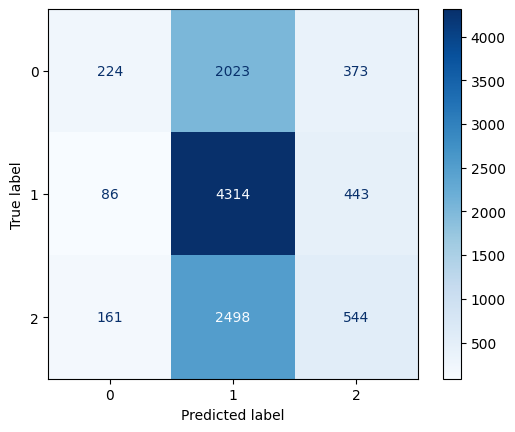

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")


In [37]:
wandb.log(eval_results)